In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
%pwd
%cd ..

c:\Users\user\Desktop\Projects\Hand_Gesture_Recognition


In [13]:
actions = ['yes', 'no', 'like', 'heart']

data = np.concatenate([
    np.load('dataset/seq_yes_1651849629.npy'),
    np.load('dataset/seq_no_1651849629.npy'),
    np.load('dataset/seq_like_1651849629.npy'),
    np.load('dataset/seq_heart_1651849629.npy')
], axis=0)

data.shape

(1036, 10, 111)

In [14]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1036, 10, 110)
(1036,)


In [15]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1036, 4)

In [16]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(932, 10, 110) (932, 4)
(104, 10, 110) (104, 4)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                44800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 47,012
Trainable params: 47,012
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/multi_hand_gesture_classifier.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
30/30 [==============================] - 2s 25ms/step - loss: 41.6751 - acc: 0.3118 - val_loss: 2.3043 - val_acc: 0.7596

Epoch 00001: val_acc improved from -inf to 0.75962, saving model to models\multi_hand_gesture_classifier.h5
Epoch 2/200
30/30 [==============================] - 0s 14ms/step - loss: 5.0859 - acc: 0.6719 - val_loss: 1.2273 - val_acc: 0.9135

Epoch 00002: val_acc improved from 0.75962 to 0.91346, saving model to models\multi_hand_gesture_classifier.h5
Epoch 3/200
30/30 [==============================] - 0s 15ms/step - loss: 2.0934 - acc: 0.8116 - val_loss: 0.3146 - val_acc: 0.9327

Epoch 00003: val_acc improved from 0.91346 to 0.93269, saving model to models\multi_hand_gesture_classifier.h5
Epoch 4/200
30/30 [==============================] - 0s 16ms/step - loss: 1.6947 - acc: 0.8409 - val_loss: 0.1966 - val_acc: 0.9519

Epoch 00004: val_acc improved from 0.93269 to 0.95192, saving model to models\multi_hand_gesture_classifier.h5
Epoch 5/200
30/30 [=======

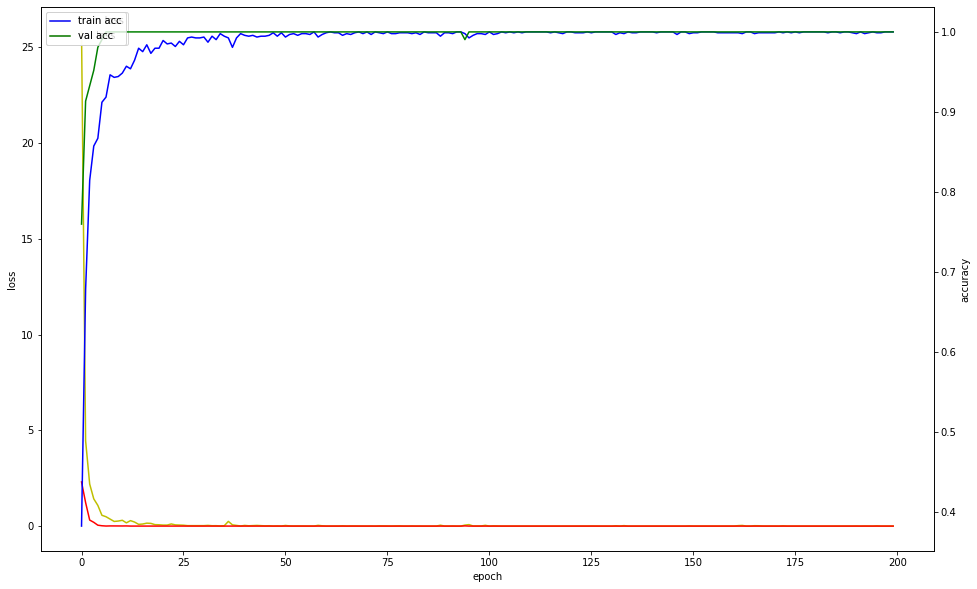

In [21]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [22]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/multi_hand_gesture_classifier.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[82,  0],
        [ 0, 22]],

       [[76,  0],
        [ 0, 28]],

       [[73,  0],
        [ 0, 31]],

       [[81,  0],
        [ 0, 23]]], dtype=int64)

In [23]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('models/multi_hand_gesture_classifier.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp8mcf3kjg\assets
